# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Análisis exploratorio y curación

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales


  * Realizar un estudio exploratorio del dataset para extraer información útil sobre el problema a resolver.
  * Desarrollar visión crítica en relación a la problemática para llevar a cabo el procedimiento de ciencia de datos.
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

## Objetivos específicos

*  Realizar un análisis profundo de los datos para identificar posibles problemas en la información proporcionada (por ejemplo datos duplicados).
*   Trabajar con diferentes encodings en las variables categóricas de manera de poder usar ciertos algoritmos de machine learning que solo aceptan datos numéricos.
* Estudiar y analizar de qué manera puede predecirse la cantidad de días en que un envío llegará a destino y qué variables tienen mayor peso en dicha predicción.



##Desarrollo del trabajo

In [0]:
import matplotlib.pyplot as plt
import numpy 
import pandas
import seaborn


from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Lectura y análisis inicial de los datos

In [0]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape


(500000, 12)

In [0]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [0]:
numpy.random.seed(0) #con propositos de reproducibilidad
dataset.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
194257,SP,3734,RS,96540,standard,1,4,done,2019-02-17,2019-02-22 03:49:21,2019-03-07 15:09:00,6.0
396319,SP,6422,SP,9580,express,1,5,done,2019-03-04,2019-03-07 20:24:02,2019-03-07 10:02:09,0.0
138738,SP,14940,CE,62650,standard,1,1,done,2019-02-08,2019-02-13 13:51:00,2019-03-11 14:16:00,15.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
149424,SP,13254,BA,44700,express,1,0,done,2019-03-02,2019-03-04 15:41:00,2019-03-12 15:19:00,3.0
128165,SP,9850,SP,12301,express,2,0,done,2019-03-17,2019-03-19 13:39:00,2019-03-20 18:59:00,1.0
264495,SP,3627,BA,44690,standard,1,1,done,2019-03-04,2019-03-06 12:13:00,2019-03-22 14:17:00,11.0
30371,SP,13456,SP,5268,express,2,0,done,2019-03-12,2019-03-13 15:07:00,2019-03-14 16:26:00,1.0
456998,SP,3004,SC,89300,standard,1,3,done,2019-02-15,2019-02-17 04:52:00,2019-03-07 17:56:00,10.0
32001,SP,19013,SP,14815,standard,2,1,done,2019-03-21,2019-03-22 14:32:00,2019-03-26 13:39:00,2.0


### Acerca de los valores de shipment_days anómalos

En el práctico anterior habiamos tomado la decisión de no trabajar con valores de la variable **shipment_days** negativos teniendo en cuenta que no los podemos considerar valores reales y que la proporción de estos datos dentro de todo el conjunto es muy chica.

Por lo tanto nuestra primera medida será aplicar este filtro.

In [0]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [0]:
dataset_clean = clean_shipment_days(dataset)

In [0]:
dataset_clean.describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,499350.000000,499350.000000,499350.000000,499350.000000,499350.000000
mean,8305.922694,39977.617365,1.278210,1.513588,5.374357
std,5088.481700,30977.339131,0.661669,1.825088,4.978010
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3673.000000,13106.000000,1.000000,0.000000,2.000000
50%,7400.000000,31140.000000,1.000000,1.000000,4.000000
75%,13277.000000,70670.000000,1.000000,2.000000,8.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


In [0]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499350 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        499350 non-null object
sender_zipcode      499350 non-null int64
receiver_state      499350 non-null object
receiver_zipcode    499350 non-null int64
shipment_type       499350 non-null object
quantity            499350 non-null int64
service             499350 non-null int64
status              499350 non-null object
date_created        499350 non-null datetime64[ns]
date_sent           499350 non-null datetime64[ns]
date_visit          499350 non-null datetime64[ns]
shipment_days       499350 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 49.5+ MB


###Datos duplicados

A continuación intentaremos determinar si nuestro dataset tiene información duplicada.

In [0]:
dataset_clean[dataset_clean.duplicated()].sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
261074,SP,6422,SP,4671,express,1,8,done,2019-02-27,2019-03-01 06:18:32,2019-03-07 12:19:58,1.0
274457,SP,6422,SP,17026,express,1,4,done,2019-03-17,2019-03-19 00:51:00,2019-03-25 17:09:00,4.0
360738,SP,2652,ES,29060,standard,2,1,done,2019-03-14,2019-03-18 09:22:00,2019-03-22 12:51:00,4.0
189806,SP,9941,SP,3140,express,1,0,done,2019-03-12,2019-03-13 15:50:00,2019-03-14 14:07:00,1.0
295470,SP,9112,SP,5818,express,1,0,done,2019-03-17,2019-03-18 19:19:00,2019-03-20 11:38:00,2.0
162811,SP,19053,DF,71988,standard,1,4,done,2019-03-17,2019-03-21 04:04:38,2019-03-25 12:15:00,2.0
333332,SP,13903,PI,64052,standard,1,1,done,2019-03-05,2019-03-06 16:19:00,2019-03-21 15:47:00,10.0
55229,SP,14405,RS,99010,standard,1,3,done,2019-02-19,2019-02-24 05:05:00,2019-03-08 22:00:00,6.0
341655,SP,2071,RJ,21310,standard,1,1,done,2019-02-22,2019-02-25 18:42:00,2019-03-27 14:52:00,19.0
399288,SP,6411,MG,35410,standard,1,1,done,2019-03-08,2019-03-11 16:52:00,2019-03-14 18:17:00,3.0


Detectamos datos duplicados, veamos ahora más específicamente.

In [0]:
dd=dataset_clean[dataset_clean.duplicated(keep=False)]
dd.sort_values("sender_zipcode")

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
53875,SP,1001,SE,49096,standard,1,1,done,2019-02-21,2019-02-25 11:45:00,2019-03-19 11:55:00,13.0
358581,SP,1001,SE,49096,standard,1,1,done,2019-02-21,2019-02-25 11:45:00,2019-03-19 11:55:00,13.0
478674,SP,1004,PR,86805,standard,1,4,done,2019-03-15,2019-03-15 22:04:41,2019-03-28 22:56:00,9.0
236014,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
416799,SP,1004,SP,18076,express,1,4,done,2019-03-19,2019-03-19 22:53:00,2019-03-22 13:52:00,3.0
395523,SP,1004,PR,83833,standard,1,4,done,2019-03-15,2019-03-15 22:04:51,2019-03-20 20:49:00,3.0
192559,SP,1004,PR,83833,standard,1,4,done,2019-03-15,2019-03-15 22:04:51,2019-03-20 20:49:00,3.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
119594,SP,1004,SP,18076,express,1,4,done,2019-03-19,2019-03-19 22:53:00,2019-03-22 13:52:00,3.0
273705,SP,1004,PR,86805,standard,1,4,done,2019-03-15,2019-03-15 22:04:41,2019-03-28 22:56:00,9.0


Podemos ver, que si los ordenamos por zipcode, tenemos datos duplicados en todas las columnas.

Tenemos 6469 filas duplicadas, podemos chequear esta cantidad con el siguiente comando:

In [0]:
dataset_clean.duplicated().sum()

6469

Eliminamos los duplicados:

In [0]:
dataset_clean = dataset_clean.drop_duplicates()

Chequeemos si quedaron duplicados:

In [0]:
dataset_clean.duplicated().sum()

0

### Análisis de fechas anómalas

In [0]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,492881,492881,492881
unique,142,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20169,112,607
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-06-28 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


Observamos lo siguiente:

* La variables **date_created** solo tiene 142 valores distintos y no considera horas (todas están seteadas a las 00:00 hs) esto implica que estamos considerando un total de 142 días distintos.
* La variable **date_created**  contienen fechas que caen fuera del intervalo temporal considerado (Junio de 2019).
* Hay una cierta variabilidad entre los mínimos de las 3 fechas, podría servir analizar los estados de las fechas fuera del periodo de **date_visit** para ver si no son anómalos.
* En la variable **date_visit** el dato más frecuente se da a las 22.00 hs, posiblemente fuera del horario de atención de los correos, con lo cual este dato es bastante extraño en un principio. Lo mismo sucede con el horario 05:36.

Teniendo en cuenta la problemática que queremos resolver, la primera observación cobra cierto sentido pues el día de creación del envío resulta mucho más importante que la hora en si misma. Además, considerando que la respuesta del problema en un principio debe consistir en dar un intervalo de días, las franjas horarias podrían no ser tenidas en cuenta a priori.

Con respecto a la segunda observación podríamos intentar determinar la cantidad de fechas que caen fuera del intervalo Octubre de 2018-Abril de 2019 y al mismo tiempo observar la tendencia a medida que pasan los meses de las variables **date_created**, **date_sent** y **date_visited**.

**Variable date_created**

In [0]:
dataset_clean['date_created'].groupby([dataset_clean['date_created'].dt.year.rename('year'), dataset_clean['date_created'].dt.month.rename('month')]).agg({'count'})


count
year month        
2018 10          1
     11          4
     12         34
2019 1        3696
     2      178777
     3      310247
     4          32
     6          90

**Observaciones:**

* Tenemos una sola fecha de creación en el mes de octubre y 98 fechas en el mes de Junio  (estas últimas caen  fuera del intervalo temporal considerado).

* La mayor concentración en cuanto a fechas de creación de envíos se dió en la franja enero-marzo, donde marzo cuenta con más de la mitad de los datos. 

**Preguntas y comentarios a tener en cuenta:**

1. ¿Es normal que en un intervalo de 6 meses los datos se concentren mayormente en un mes o dos?
2. ¿Podemos pensar que los 98 datos  junio de 2019 hayan tenido que ver con errores de carga de los  datos y sean efectivamente datos que se encuentran en el intervalo considerado? ¿O efectivamente serán datos que tenemos que eliminar de nuestro conjunto de análisis?

**Variable date_sent**

In [0]:
dataset_clean['date_sent'].groupby([dataset_clean['date_sent'].dt.year.rename('year'), dataset_clean['date_sent'].dt.month.rename('month')]).agg({'count'})

count
year month        
2018 10          1
     11          2
     12         11
2019 1        2386
     2      150603
     3      339878


**Observaciones:**

No se observan datos fuera del intervalo considerado pero si una gran concentración en el intervalo enero-marzo, así como sucedía con la variable date_created.

**Variable date_visit**

In [0]:
dataset_clean['date_visit'].groupby([dataset_clean['date_visit'].dt.year.rename('year'), dataset_clean['date_visit'].dt.month.rename('month')]).agg({'count'})

count
year month        
2019 2       27704
     3      463832
     4        1345

**Observaciones y preguntas a tener en cuenta**

* No se observan datos anómalos en la variable **date_visit** pero no contamos con información en los meses del año 2018.
* ¿Qué sucede con los envíos creados y enviados durante 2018? ¿Llegaron a destino?

### Análisis de la variable date_created

Ahora vamos a analizar el valor del mes de octubre y las 98 fechas de creación del mes de junio  para ver si encontramos alguna anomalía.

**Octubre 2018**

In [0]:
date_created_octubre = dataset_clean['date_created'].map(lambda x: x.month) == 10
dataset_clean[date_created_octubre]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
108620,SP,6220,MA,65470,standard,1,1,failed,2018-10-21,2018-10-23 13:57:00,2019-03-13 16:58:00,90.0


Este envío cuenta con información en todas las columnas. Resulta extraño claro que el envío haya tardado 90 días en llegar a destino  lo cual no se corresponde con las fechas en las variables date_sent  y date_visit (octubre y marzo respectivamente). Además 90 días resulta en un valor demasiado grande para la variable shipment_days.

Como es un solo dato, a priori decidimos dejarlo. Quizás en un futuro pueda ser descartado.

**Junio de 2019**

In [0]:
date_created_junio = dataset_clean['date_created'].map(lambda x: x.month) == 6
dataset_clean[date_created_junio].sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
220920,SP,3106,RJ,21031,standard,1,7,done,2019-06-27,2019-02-06 06:16:00,2019-03-01 11:20:00,17.0
463948,SP,3375,ES,29160,standard,2,7,done,2019-06-26,2019-03-06 03:02:00,2019-03-07 06:26:00,0.0
235918,SP,7411,RJ,21020,express,1,7,done,2019-06-24,2019-02-06 03:52:00,2019-03-01 12:48:00,17.0
115505,SP,1536,SP,11055,express,1,7,done,2019-06-03,2019-02-06 04:51:00,2019-03-01 08:17:00,17.0
136249,SP,12950,PE,51030,standard,1,4,failed,2019-06-19,2019-02-06 09:48:00,2019-03-01 02:41:00,17.0
415973,SP,2950,RS,96835,standard,1,7,done,2019-06-10,2019-03-06 03:56:00,2019-03-07 04:02:00,0.0
89842,SP,6422,CE,60833,standard,1,4,done,2019-06-14,2019-03-06 11:42:00,2019-03-07 11:42:00,0.0
175596,SP,6422,RS,97502,standard,1,7,done,2019-06-21,2019-02-06 11:45:00,2019-03-01 11:08:00,17.0
155665,SP,1224,SP,14940,standard,1,4,done,2019-06-25,2019-02-06 11:59:00,2019-03-01 11:02:00,17.0
402015,SP,9360,RJ,22411,express,1,7,done,2019-06-27,2019-02-06 06:24:00,2019-03-01 16:04:00,17.0


Si bien estos datos caen fuera de los supuestos en cuanto a que la fecha de creación debe ser anterior a la fecha de envío, la inspección de los datos de arriba nos inclina a pensar que los datos con fecha de creación en junio de 2019 en realidad corresponden a datos del mes de enero del mismo año. Esta suposición se basa en que las fechas de las variables **date_sent** y **date_visit** muestran una cierta coherencia entre sí y con la variable **shipment_days**. 

Esta hipótesis plantea la disyuntiva de si esta información debe ser eliminada o si las fechas de creación de junio deben ser modificadas poniendo en su lugar enero de 2019.

Si uno se guía por los datos "como vienen" la primera opción sería eliminar estas filas (ya que la cantidad de las mismas no afectaría a la cantidad total). Sin embargo podemos tomar la jugada arriesgada y "modificar" nuestros datos subsanando de esta manera un posible error producido durante la carga de los datos. Creemos que para un análisis en un futuro cercano podemos imputar los datos de creación de junio poniéndoles fecha de enero.

### Encoding la variable categórica receiver_state

**LabelEncoder**

LabelEncoder codifica datos categóricos asignandole un valor numérico desde 0 a n (donde n es la cantidad de datos). De esta manera establece una escala de importancia entre los mismos lo cual no siempre es adecuado.

In [0]:
receiver_state_le='receiver_state'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset_clean[receiver_state_le])

LabelEncoder()

In [0]:
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'AC': 0,
 'AL': 1,
 'AM': 2,
 'AP': 3,
 'BA': 4,
 'CE': 5,
 'DF': 6,
 'ES': 7,
 'GO': 8,
 'MA': 9,
 'MG': 10,
 'MS': 11,
 'MT': 12,
 'PA': 13,
 'PB': 14,
 'PE': 15,
 'PI': 16,
 'PR': 17,
 'RJ': 18,
 'RN': 19,
 'RO': 20,
 'RR': 21,
 'RS': 22,
 'SC': 23,
 'SE': 24,
 'SP': 25,
 'TO': 26}

De acuerdo al encoding anterior San Pablo (número 25) resulta un estado más importante que Minas Gerais (número 10).

In [0]:
dict1=dict(zip(le.classes_,le.transform(le.classes_)))
receiver_state_le=[]

In [0]:
for row in dataset_clean['receiver_state']:
    receiver_state_le.append(dict1[row])

In [0]:
dataset_clean['receiver_state_le']=receiver_state_le
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le
408437,SP,13290,SP,4533,super,1,6,done,2019-03-05,2019-03-05 21:24:10,2019-03-08 13:56:59,1.0,25
53041,SP,14405,MG,33920,express,1,0,done,2019-03-05,2019-03-05 16:33:00,2019-03-12 13:26:00,3.0,10
92797,SP,3461,SP,4803,express,4,0,done,2019-03-10,2019-03-11 12:11:00,2019-03-18 09:01:00,5.0,25
372081,SP,3658,SP,2721,express,1,0,done,2019-03-19,2019-03-20 12:23:00,2019-03-21 11:12:00,1.0,25
319590,SP,4141,DF,71907,express,1,0,done,2019-02-27,2019-02-28 15:20:00,2019-03-01 14:05:00,1.0,6


**OneHotEncoding**

Este encoding convierte cada valor de categoría en una nueva columna y asigna un valor de 1 ó 0 a la columna. A diferencia del anterior no establece una escala de importancia entre las variables categóricas, sin embargo agrega más columnas al conjunto de datos que en nuestro caso serían 27!!

In [0]:
dataset_ohe= pandas.get_dummies(dataset_clean, columns=["receiver_state"])
dataset_ohe.head()

,sender_state,sender_zipcode,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,receiver_state_AC,receiver_state_AL,receiver_state_AM,receiver_state_AP,receiver_state_BA,receiver_state_CE,receiver_state_DF,receiver_state_ES,receiver_state_GO,receiver_state_MA,receiver_state_MG,receiver_state_MS,receiver_state_MT,receiver_state_PA,receiver_state_PB,receiver_state_PE,receiver_state_PI,receiver_state_PR,receiver_state_RJ,receiver_state_RN,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO
0,SP,1039,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,SP,3004,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,SP,3262,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,SP,12237,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,SP,9350,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### ¿Cuándo llega?: Features más importantes

Uno de los objetivos principales de nuestro análisis es predecir (dar un número aproximado de días hábiles) de cuanto va a tardar en llegar un envío desde que el cliente realiza la compra a través de la plataforma de Mercado Libre hasta que el paquete llega a su casa.

Esto nos lleva a pensar que dicha predicción se parecerá a los valores de la variable **shipment_days** con, quizás, 1 o 2 días más de diferencia. Pues este último feature cuenta el intervalo de días entre date_sent y date_visit y nosotros necesitamos dar la aproximación a partir del momento de la compra.


Frente a este problema consideramos que el estado de Brasil que recibe el envío (**receiver_state**) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más).  Por otro lado, el tipo de correo (**service**) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.

### Aplicando un modelo KKN a nuestros datos

Nos interesa determinar si un envío llegará entre 0-1 días, 2-3 días, 4-5 días, 6-7 días, 8-9 días ó 10 o más días para ello separaremos la variable **shipment_days** en clases.

In [0]:
shipment_days = dataset_clean['shipment_days']
shipment_days_byclass= [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if row in (0,1):
        shipment_days_byclass[line]='0-1 dias'
    elif row in (2,3):
        shipment_days_byclass[line] = '2-3 dias'            
    elif row in (4,5):
        shipment_days_byclass[line] = '4-5 dias'
    elif row in (6,7):
        shipment_days_byclass[line] = '6-7 dias'
    elif row in (8,9):
        shipment_days_byclass[line] = '8-9 dias'
    else:
        shipment_days_byclass[line] = '10 o mas dias'

In [0]:
dataset_clean['shipment_days_byclass'] = shipment_days_byclass

In [0]:
dataset_clean.sample(6)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le,shipment_days_byclass
345508,SP,14401,BA,45140,standard,1,1,done,2019-03-14,2019-03-15 16:58:00,2019-03-26 10:33:00,7.0,4,6-7 dias
459829,SP,13306,MG,37660,standard,1,3,done,2019-03-05,2019-03-06 19:53:00,2019-03-11 15:32:00,2.0,10,2-3 dias
264798,SP,12940,MG,38413,standard,1,2,done,2019-03-05,2019-03-11 14:28:12,2019-03-12 18:34:00,1.0,10,0-1 dias
128824,SP,6422,RJ,28680,express,1,4,done,2019-02-27,2019-03-01 08:57:16,2019-03-11 13:10:00,3.0,18,2-3 dias
187688,SP,13026,SP,2976,express,1,4,done,2019-03-23,2019-03-26 16:32:53,2019-03-28 09:55:00,2.0,25,2-3 dias
233636,SP,3427,SP,2617,express,1,0,done,2019-03-11,2019-03-12 16:57:00,2019-03-14 14:53:00,2.0,25,2-3 dias


A continuación vamos a aplicar un procedimiento de clustering (algoritmo knn) utilizando como valores de entradas los features **service** y **receiver_zipcode**.

In [0]:
X=dataset_clean[['service','receiver_zipcode']]
y=dataset_clean['shipment_days_byclass']

Separamos algunos valores para el conjunto de validación (terminado en test) y para entrenar (terminado en train).




In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Una cantidad de 3 vecinos se utilizó como veremos a continuación:



In [0]:
n_neighbors = 3
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.57
Accuracy of K-NN classifier on test set: 0.50


Como notamos en los valores de accuracy la clasificación no es tan buena. Recordemos que el accuracy indica la proporción de datos que fueron clasificados como se esperaba.

Veamos a continuación la matriz de confusión y el reporte de la clasificación.

In [0]:
y_pred = knn.predict(X_test)

In [0]:
print(confusion_matrix(y_test, y_pred))  

[[18955    98  7592   524    55    12]
 [  183 18162   770  1280  1465  1680]
 [ 9712  1505 17999  3811   586   173]
 [ 1780  3436  6354  4477  1334   476]
 [  498  5106  1810  2027  1307   786]
 [  160  5643   659  1006   962   838]]


In [0]:
print(classification_report(y_test, y_pred))  

               precision    recall  f1-score   support

     0-1 dias       0.61      0.70      0.65     27236
10 o mas dias       0.53      0.77      0.63     23540
     2-3 dias       0.51      0.53      0.52     33786
     4-5 dias       0.34      0.25      0.29     17857
     6-7 dias       0.23      0.11      0.15     11534
     8-9 dias       0.21      0.09      0.13      9268

     accuracy                           0.50    123221
    macro avg       0.41      0.41      0.39    123221
 weighted avg       0.46      0.50      0.47    123221



En el mismo podemos ver,  por cada clase la precisión obtenida por el clasificador. Y el accuracy promedio macro y weighted en 0.41 y 0.46 respectivamente.
Ahora intentaremos mostrar una mejor visualización de la matriz de confusión.

In [0]:
cm=confusion_matrix(y_test, y_pred)

In [0]:
df_cm = pandas.DataFrame(cm, range(6),
                  range(6))

In [0]:
classes=dataset_clean['shipment_days_byclass'].unique()
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

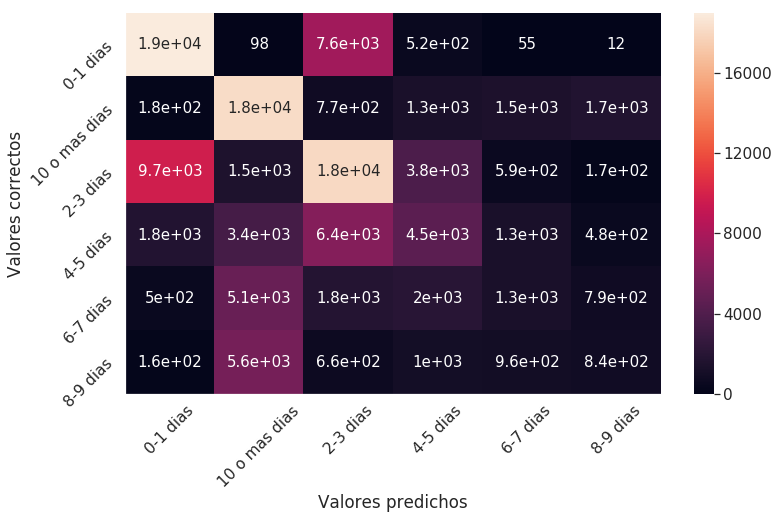

In [0]:
plt.figure(figsize=(12,7))
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()

La matrix de confusión la podemos leer como por ejemplo:

En la clase 10 o más días se predijieron 98 valores que corresponden a la clase 0-1 dias.
En la clase 6-7 días se predijieron 55 valores que en realidad pertenecen a la clase 0-1 dias.
En la clase 8-9 días se predijieron 12 valores, que corresponden a la clase 0-1dias.

Veamos como quedan los clusters:

In [0]:
dataset_clean.shape

(492881, 14)

In [0]:
X = dataset_clean[["service","receiver_zipcode"]].values.reshape(492881,2)
y = dataset_clean[["shipment_days_byclass"]].values

Necesitamos obtener los colores para la clasificación, lo cual lo sacaremos con el primer caracter:

In [0]:
y_c = numpy.zeros(y.size)
for i in numpy.arange(y.size):
    y_c[i]=y[i][0][0]

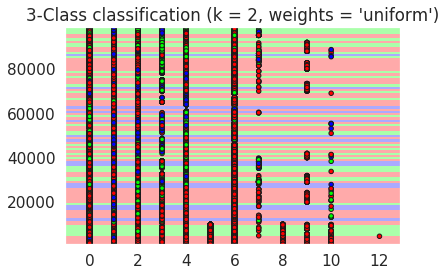

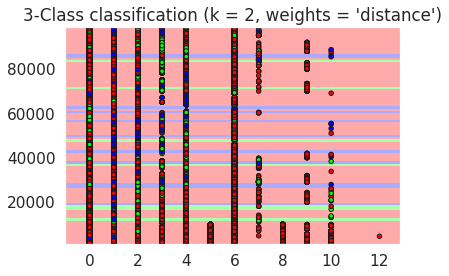

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 2

# import some data to play with
#iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
#X = iris.data[:, :2]
#y = iris.target

h = .2  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y.ravel())

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h1= numpy.absolute(x_max-x_min)/100
    h2= numpy.absolute(y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h1),
                         np.arange(y_min, y_max, h2))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    z_c = numpy.zeros((100,100))
    for i in numpy.arange(100):
        for j in numpy.arange(100):
            z_c[i]=Z[i][j][0]     
    
    plt.figure()
    plt.pcolormesh(xx, yy, z_c, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1],c=y_c, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

A continuación hacemos seleccionamos otros features (service, receiver_state_le), para ver como se comporta knn.

In [0]:
X=dataset_clean[['service','receiver_state_le']]
y=dataset_clean['shipment_days_byclass']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 3
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.46
Accuracy of K-NN classifier on test set: 0.46


In [0]:
y_pred = knn.predict(X_test)

In [0]:
print(confusion_matrix(y_test, y_pred))  

[[22599    26  3318  1253    29    11]
 [  278 14265   164  3384  3024  2425]
 [14719   737  9644  7585   812   289]
 [ 2718  1520  4305  6117  2237   960]
 [  758  2904  1143  2862  2446  1421]
 [  271  3943   314  1602  1884  1254]]


In [0]:
print(classification_report(y_test, y_pred))  

               precision    recall  f1-score   support

     0-1 dias       0.55      0.83      0.66     27236
10 o mas dias       0.61      0.61      0.61     23540
     2-3 dias       0.51      0.29      0.37     33786
     4-5 dias       0.27      0.34      0.30     17857
     6-7 dias       0.23      0.21      0.22     11534
     8-9 dias       0.20      0.14      0.16      9268

     accuracy                           0.46    123221
    macro avg       0.39      0.40      0.39    123221
 weighted avg       0.45      0.46      0.44    123221



In [0]:
cm=confusion_matrix(y_test, y_pred)

In [0]:
df_cm = pandas.DataFrame(cm, range(6),
                  range(6))

In [0]:
classes=dataset_clean['shipment_days_byclass'].unique()
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

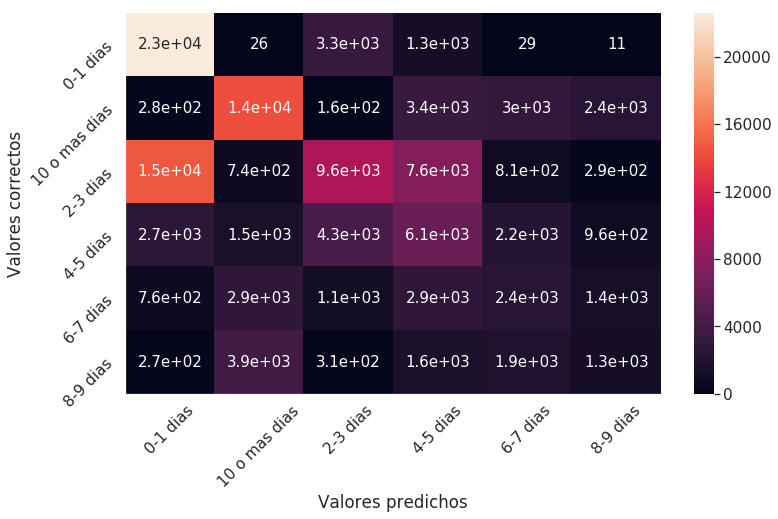

In [0]:
plt.figure(figsize=(12,7))
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()



Y por ultimo probemos con los features service, receiver_state_le y receiver_zipcode para ver si se mejora el accuracy:

In [0]:
X=dataset_clean[['service','receiver_state_le','receiver_zipcode']]
y=dataset_clean['shipment_days_byclass']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
n_neighbors = 3
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.57
Accuracy of K-NN classifier on test set: 0.50


In [0]:
y_pred = knn.predict(X_test)

In [0]:
print(confusion_matrix(y_test, y_pred))  

[[18996    94  7550   521    59    16]
 [  176 17701   853  1326  1587  1897]
 [ 9767  1517 17979  3731   578   214]
 [ 1784  3427  6433  4432  1266   515]
 [  499  4923  1919  2068  1248   877]
 [  168  5497   755  1010   912   926]]


In [0]:
print(classification_report(y_test, y_pred))  

               precision    recall  f1-score   support

     0-1 dias       0.61      0.70      0.65     27236
10 o mas dias       0.53      0.75      0.62     23540
     2-3 dias       0.51      0.53      0.52     33786
     4-5 dias       0.34      0.25      0.29     17857
     6-7 dias       0.22      0.11      0.15     11534
     8-9 dias       0.21      0.10      0.14      9268

     accuracy                           0.50    123221
    macro avg       0.40      0.41      0.39    123221
 weighted avg       0.46      0.50      0.47    123221



In [0]:
cm=confusion_matrix(y_test, y_pred)

In [0]:
df_cm = pandas.DataFrame(cm, range(6),
                  range(6))

In [0]:
classes=dataset_clean['shipment_days_byclass'].unique()
classes.sort()
classes

array(['0-1 dias', '10 o mas dias', '2-3 dias', '4-5 dias', '6-7 dias',
       '8-9 dias'], dtype=object)

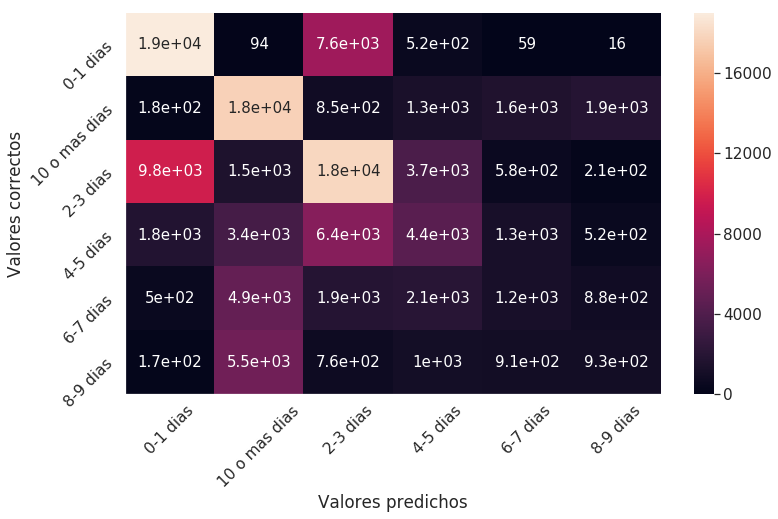

In [0]:
plt.figure(figsize=(12,7))
seaborn.set(font_scale=1.4)
seaborn.heatmap(df_cm, annot=True,annot_kws={"size": 15},xticklabels=classes, yticklabels=classes)
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.xlabel('Valores predichos')
plt.ylabel('Valores correctos')
seaborn.despine()

Conclusión:
En la primera selección de features y en la última estamos obteniendo el mismo accuracy, por ende se podría usar cualquiera de ambas. La segunda al tener un mas bajo accuracy descartamos esa selección de features para un futuro.
Igual comparado con otros resultados (de ejemplos de otros data set) consideramos que knn con nuestros datos no estamos obteniendo los resultados esperados. A un futuro podríamos utilizar otros clasificadores automáticos o no.